## Sentiment Analysis
> First we train the Convolutional Neural Network on 'training_20k.txt' or 'training_50k.txt'. The CNN model returns accuracy. After the training, a pickle file is saved of the model.
This pickle file is used to test the performance of model on unseen data.
> To run on augmented data change train file name.

* The difference between training and unseen data accuracy should be minimum. UNSEEN ACCURACY can be lower than training.

In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
import keras.layers as layers
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,f1_score,average_precision_score,confusion_matrix,roc_auc_score,roc_curve
import pandas as pd
import math
import time
import numpy as np
import random
from random import randint
random.seed(3)
import datetime, re, operator
from random import shuffle
from time import gmtime, strftime
import seaborn as sns
import gc
import matplotlib.pyplot as plt
import joblib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #get rid of warnings
from os import listdir
from os.path import isfile, join, isdir
import pickle
import csv

Using TensorFlow backend.
/home/shivani/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shivani/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shivani/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shivani/.local/lib/python3.7/site-packages/tensorflow/py

In [2]:
#--------------------------------------------------
#--Globals------------------------------------------
num_classes=2
input_size=50
word2vec_len=300
percent_dataset=0.1
#sentiment_analysis_path = '../data/sentiment_analysis/'
huge_word2vec = 'glove.840B.300d.txt'
train_file = 'training_50k.txt'
test_file = 'testing.txt'
unseen_data = 'unseen_original.csv'
unseen_test_csv = 'unseen_test.csv'
unseen_test_txt ="unseen_test.txt"
#------------------------------------------------------
#---------------------------------------------------

In [3]:
def load_pickle(file):
    return pickle.load(open(file, 'rb'))

##### Download word2vec (File Size - 5.2GB)

In [4]:
#!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

In [5]:
#!unzip glove.840B.300d.zip

In [6]:
def gen_vocab_dicts(output_pickle_path, huge_word2vec,train_file):

    vocab = set()
    text_embeddings = open(huge_word2vec, 'r').readlines()
    word2vec = {}
    try:
        all_lines = open(train_file, "r").readlines()
        for line in all_lines:
            words = line[:-1].split(' ')
            for word in words:
                vocab.add(word)
    except:
        print(txt_path, "has an error")
    
    print(len(vocab), "unique words found")

    # load the word embeddings, and only add the word to the dictionary if we need it
    for line in text_embeddings:
        items = line.split(' ')
        word = items[0]
        if word in vocab:
            vec = items[1:]
            word2vec[word] = np.asarray(vec, dtype = 'float32')
    print(len(word2vec), "matches between unique words and word2vec dictionary")
        
    pickle.dump(word2vec, open(output_pickle_path, 'wb'))
    print("dictionaries outputted to", output_pickle_path)

In [7]:
gen_vocab_dicts('word2vec.p',huge_word2vec,train_file)

131961 unique words found
35302 matches between unique words and word2vec dictionary
dictionaries outputted to word2vec.p


In [8]:
word2vec_pickle ='word2vec.p'
word2vec = load_pickle(word2vec_pickle)

In [9]:
def run_cnn(train_file, test_file, num_classes, percent_dataset):
    
    #initialize model
    model = build_cnn(input_size, word2vec_len, num_classes)
    
    #load data
    train_x, train_y = get_x_y(train_file, num_classes, word2vec_len, input_size, word2vec, percent_dataset)
    test_x, test_y = get_x_y(test_file, num_classes, word2vec_len, input_size, word2vec, 1)
    
    #implement early stopping
    callbacks = [EarlyStopping(monitor='val_loss', patience=3)]
    
    #train model
    model.fit(train_x, 
              train_y, 
              epochs=10000000, 
              callbacks=callbacks,
              validation_split=0.1, 
              batch_size=1024, 
              shuffle=True, 
              verbose=0)
    pickle.dump(model, open('trained_model.pkl', 'wb'))

    #model = load_model('checkpoints/lol')

    #evaluate model
    #print(type(test_x))
    #print(test_x)
    y_pred = model.predict(test_x)
    test_y_cat = one_hot_to_categorical(test_y)
    y_pred_cat = one_hot_to_categorical(y_pred)
    acc = accuracy_score(test_y_cat, y_pred_cat)
    print(acc)
    #clean memory
    train_x, train_y, test_x, test_y, model = None, None, None, None, None
    gc.collect()
    
    #print other metrics 
    
    print("F1 Score: {0:0.2f}".format(f1_score(test_y_cat,y_pred_cat)))
    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_score(test_y_cat,y_pred_cat)))
    cf_matrix=confusion_matrix(test_y_cat,y_pred_cat)
    sns.heatmap(cf_matrix, annot=True)
    print("No of wrong predictions:{}".format(cf_matrix[0][1]+cf_matrix[1][0]))
    print("Roc Auc Score: {0:0.2f}".format(roc_auc_score(test_y_cat,y_pred_cat)))
    fpr, tpr, thresholds = roc_curve(test_y_cat,y_pred_cat)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    #return the accuracy
    #print("data with shape:", train_x.shape, train_y.shape, 'train=', train_file, 'test=', test_file, 'with fraction', percent_dataset, 'had acc', acc
    return acc*100

### Convolutional Neural Network

In [10]:
def build_cnn(sentence_length, word2vec_len, num_classes):
    model = None
    model = Sequential()
    model.add(layers.Conv1D(128, 5, activation='relu', input_shape=(sentence_length, word2vec_len)))
    model.add(layers.GlobalMaxPooling1D())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
def get_x_y(train_txt, num_classes, word2vec_len, input_size, word2vec, percent_dataset):
    
    #read in lines
    #print(train_txt)
    train_lines = open(train_txt, 'r').readlines()
    shuffle(train_lines)
    train_lines = train_lines[:int(percent_dataset*len(train_lines))]
    num_lines = len(train_lines)
    
    #initialize x and y matrix
    x_matrix = None
    y_matrix = None
    try:
        x_matrix = np.zeros((num_lines, input_size, word2vec_len))
    except:
        print("Error!", num_lines, input_size, word2vec_len)
    y_matrix = np.zeros((num_lines, num_classes))
    
    #insert values
    for i, line in enumerate(train_lines):
        parts = line[:-1].split('\t')
        label = int(parts[0])
        sentence = parts[1]
        
        #insert x
        words = sentence.split(' ')
        words = words[:x_matrix.shape[1]] #cut off if too long
        for j, word in enumerate(words):
            if word in word2vec:
                x_matrix[i, j, :] = word2vec[word]
        
        #insert y
        y_matrix[i][label] = 1.0
    return x_matrix, y_matrix

In [12]:
def one_hot_to_categorical(y):
    assert len(y.shape) == 2
    return np.argmax(y, axis=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


No handles with labels found to put in legend.


0.8536
F1 Score: 0.92
Average precision-recall score: 0.86
No of wrong predictions:1464
Roc Auc Score: 0.55


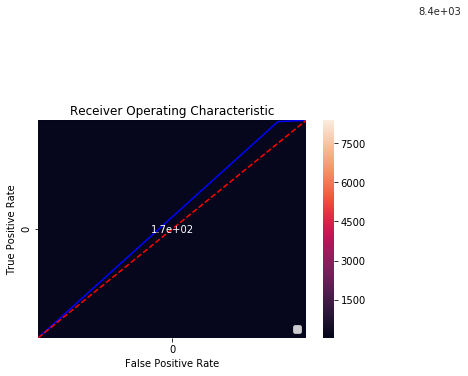

In [13]:
train_accuracy = run_cnn(train_file,test_file,num_classes,percent_dataset)

----

## Testing on unseen data

In [10]:
import csv
file = unseen_test_csv
file_name, file_ext = os.path.splitext(file)
with open(file,'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    newfile = unseen_test_txt

    for line in csv_reader:
        with open(newfile, 'a') as new_txt:    #new file has .txt extn
            txt_writer = csv.writer(new_txt, delimiter = '\t') #writefile
            txt_writer.writerow(line)  

In [11]:
model=joblib.load('trained_model.pkl')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
test_x, test_y = get_x_y(unseen_test_txt, num_classes, word2vec_len, input_size, word2vec, 1)

In [ ]:
y_pred=model.predict(test_x)
test_y_cat = one_hot_to_categorical(test_y)
y_pred_cat = one_hot_to_categorical(y_pred)
unseenDataAccuracy = abs(accuracy_score(test_y_cat, y_pred_cat)*100)
print("Training Accuracy - {} \n Unseen Data Accuracy - {}".format(train_accuracy,unseenDataAccuracy))

In [ ]:
print("F1 Score: {0:0.2f}".format(f1_score(test_y_cat,y_pred_cat)))
print('Average precision-recall score: {0:0.2f}'.format(
  average_precision_score(test_y_cat,y_pred_cat)))
cf_matrix=confusion_matrix(test_y_cat,y_pred_cat)
sns.heatmap(cf_matrix, annot=True)
print("No of wrong predictions:{}".format(cf_matrix[0][1]+cf_matrix[1][0]))
print("Roc Auc Score: {0:0.2f}".format(roc_auc_score(test_y_cat,y_pred_cat)))
fpr, tpr, thresholds = roc_curve(test_y_cat,y_pred_cat)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()